# 1. Load dataset

First, load the dataset as it was downloaded or load from a cache.

In [1]:
import pickle
from pathlib import Path

from sklearn.datasets import load_files


def load_files_and_pickle(data_dir: str , cache_path: Path):
    """Load dataset from cache if existent else load from original files and save cache."""
    dataset = None
    
    if cache_path.is_file():
        with cache_path.open("rb") as f:
            dataset = pickle.load(f)
    else:
        dataset = load_files(data_dir, categories=["pos", "neg"])
        
        with cache_path.open("wb") as f:
            pickle.dump(dataset, f)
    return dataset
            
        
reviews_train = load_files_and_pickle("aclImdb/train/", Path("acl_train_pickle"))
reviews_test = load_files_and_pickle("aclImdb/test/", Path("acl_test_pickle"))

# 2. Filter HTML breakline tags

The reviews are filtered to clear any HTML `<br>` tags, which the reviews still contain.

In [2]:
train_text = [doc.replace(b"<br />", b" ") for doc in reviews_train.data]
test_text = [doc.replace(b"<br />", b" ") for doc in reviews_test.data]
# Alias these for later use
y_train = reviews_train.target
y_test = reviews_test.target

# 3. Create a pipeline with LogisticRegression

In this step, a pipeline is created, which will first run the data through a TfidfVectorizer,
which will extract n-grams from the reviews.

Then, the LogisticRegression algorithm will be trained with this data.

In [3]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model_filename = "model.joblib"
ngram_range = (1, 3)
logreg_C = 100
logreg_max_iter = 500

In [4]:
if Path(model_filename).is_file():
    pipe = joblib.load(model_filename)
else:
    pipe = make_pipeline(
        TfidfVectorizer(ngram_range=ngram_range, min_df=5),
        LogisticRegression(max_iter=logreg_max_iter, solver='saga', C=logreg_C)
    )

    pipe.fit(train_text, y_train)
    joblib.dump(pipe, model_filename)

# 4. Test the model

Test the model with random examples.

In [5]:
pipe.predict(["This film was quite good", "I did not particularly enjoy the film"])

array([1, 0])

This calculates the mean accuracy of the model.

In [6]:
pipe.score(test_text, y_test)

0.9036

# 5. Loss Curves

With `LearningCurveDisplay`, the score can be shown as a function of the number of samples in the training set

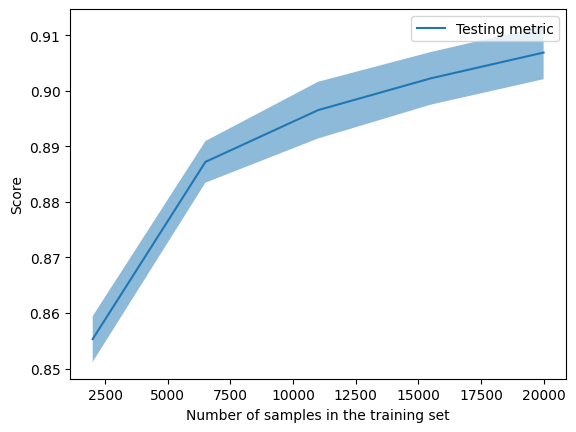

In [7]:
from sklearn.model_selection import LearningCurveDisplay

loss_pipe = make_pipeline(
    TfidfVectorizer(ngram_range=ngram_range, min_df=5),
    LogisticRegression(max_iter=logreg_max_iter, solver='saga', C=logreg_C)
)


LearningCurveDisplay.from_estimator(loss_pipe, X=train_text, y=y_train)